In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import time

In [2]:
df = pd.read_csv('data/train_data.csv',index_col="調査日",parse_dates=True)

In [3]:
def make_dataset(raw_data, look_back):
    _X = []
    _y = []

    for i in range(len(raw_data) - look_back):
        _X.append(raw_data[i : i + look_back])
        _y.append(raw_data[i + look_back])
    _X = np.array(_X).reshape(len(_X), look_back, 1)
    _y = np.array(_y).reshape(len(_y), 1)

    return _X, _y

In [4]:
df_X = df[[col for col in df.columns if col not in ['キャベツ']]]
df_y = df["キャベツ"]

In [5]:
#0〜1にスケーリング
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()
df_scale_X = pd.DataFrame(scaler_X.fit_transform(df),index=df.index,columns=df.columns)
df_scale_y = pd.DataFrame(scaler_y.fit_transform(df_y[:,np.newaxis]).flatten(),index=df.index)

/Users/atsukawakenta/opt/anaconda3/envs/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


In [6]:

df


,キャベツ,愛知平均気温,愛知降水量の合計,愛知日照時間,千葉平均気温,千葉降水量の合計,千葉日照時間,群馬平均気温,群馬降水量の合計,群馬日照時間
調査日,,,,,,,,,,
2017-01-02,231,8.085714,1.357143,7.357143,8.257143,0.642857,6.414286,-2.185714,2.857143,6.028571
2017-01-09,210,7.300000,3.285714,4.814286,7.942857,7.142857,5.485714,-2.957143,2.071429,4.385714
2017-01-16,197,5.157143,1.857143,4.914286,5.314286,0.000000,8.071429,-5.742857,2.642857,3.157143
2017-01-23,199,5.128571,0.000000,5.800000,6.414286,1.428571,6.500000,-6.171429,3.357143,4.728571
2017-01-30,202,5.485714,0.785714,6.785714,8.085714,0.214286,7.171429,-3.771429,0.857143,5.085714
...,...,...,...,...,...,...,...,...,...,...
2022-02-07,170,5.100000,0.000000,6.228571,5.071429,0.000000,7.828571,-6.057143,0.285714,5.585714
2022-02-14,193,5.842857,3.714286,4.285714,6.114286,12.285714,3.228571,-4.528571,3.357143,5.457143
2022-02-21,192,5.042857,2.357143,6.528571,6.328571,7.571429,5.571429,-5.585714,2.357143,2.042857


In [7]:
look_back=12
X_kyabetu, y_kyabetu = make_dataset(df_scale_X["キャベツ"], look_back=look_back)
X_aititemp, y_aititemp = make_dataset(df_scale_X["愛知平均気温"], look_back=look_back)
X_aitirain, y_aitirain = make_dataset(df_scale_X["愛知降水量の合計"], look_back=look_back)
X_aitisum, y_aitisum = make_dataset(df_scale_X["愛知日照時間"], look_back=look_back)
X_chibatemp, y_chibatemp = make_dataset(df_scale_X["千葉平均気温"], look_back=look_back)
X_chibarain, y_chibarain = make_dataset(df_scale_X["千葉降水量の合計"], look_back=look_back)
X_chibasum, y_chibasum = make_dataset(df_scale_X["千葉日照時間"], look_back=look_back)
X_gunmatemp, y_gunmatemp = make_dataset(df_scale_X["群馬平均気温"], look_back=look_back)
X_gunmarain, y_gunmarain = make_dataset(df_scale_X["群馬降水量の合計"], look_back=look_back)
X_gunmasum, y_gunmasum = make_dataset(df_scale_X["群馬日照時間"], look_back=look_back)

In [8]:
X_con = np.concatenate([X_kyabetu, X_aititemp, X_aitirain, X_aitisum,X_chibatemp,X_chibarain,
                        X_chibasum,X_gunmatemp,X_gunmarain,X_gunmasum],axis=2)

In [9]:
X_con.shape

(259, 12, 10)

In [10]:
X = X_con
y = y_kyabetu

# データを過去分（訓練に用いる分）と未来分（未来の予測に用いる分）に分割
X_past = X[:-24]
X_future = X[-24:]
y_past = y[:-24]
y_future = y[-24:]

# 訓練データを定義
X_train = X_past
y_train = y_past

In [11]:
X_train.shape

(235, 12, 10)

In [12]:
y_train.shape

(235, 1)

In [13]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

model = Sequential()
x = model.add(LSTM(10, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(8))
model.add(Dense(1)) #出力層はデータ数に合わせる

model.compile(loss='mean_squared_error', optimizer='adam')

2022-03-29 09:41:12.185002: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-29 09:41:12.185389: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [14]:
history = model.fit(X_train, y_train, epochs=100, batch_size=1)

Train on 235 samples
Epoch 1/100


2022-03-29 09:41:13.991626: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_4998_5467_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_5565' and '__inference___backward_standard_lstm_4998_5467' both implement 'lstm_acc615cc-8d67-4212-839d-9e1703ebae84' but their signatures do not match.


235/235 [==============================] - 7s 31ms/sample - loss: 0.8447
Epoch 2/100
235/235 [==============================] - 4s 18ms/sample - loss: 0.5057
Epoch 3/100
235/235 [==============================] - 4s 18ms/sample - loss: 0.3597
Epoch 4/100
235/235 [==============================] - 4s 18ms/sample - loss: 0.2512
Epoch 5/100
235/235 [==============================] - 4s 18ms/sample - loss: 0.1992
Epoch 6/100
235/235 [==============================] - 5s 21ms/sample - loss: 0.1800
Epoch 7/100
235/235 [==============================] - 5s 20ms/sample - loss: 0.1398
Epoch 8/100
235/235 [==============================] - 7s 28ms/sample - loss: 0.1186
Epoch 9/100
235/235 [==============================] - 5s 21ms/sample - loss: 0.1403
Epoch 10/100
235/235 [==============================] - 5s 19ms/sample - loss: 0.0952
Epoch 11/100
235/235 [==============================] - 6s 24ms/sample - loss: 0.0884
Epoch 12/100
235/235 [==============================] - 5s 23ms/sample - lo

235/235 [==============================] - 5s 21ms/sample - loss: 0.0127
Epoch 97/100
235/235 [==============================] - 6s 25ms/sample - loss: 0.0141
Epoch 98/100
235/235 [==============================] - 7s 29ms/sample - loss: 0.0116
Epoch 99/100
235/235 [==============================] - 6s 25ms/sample - loss: 0.0073
Epoch 100/100
235/235 [==============================] - 5s 21ms/sample - loss: 0.0096


In [15]:
predictions = model.predict(X_past)
future_predictions = model.predict(X_future)

2022-03-29 10:12:49.704883: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_52911' and '__inference_standard_lstm_52800_specialized_for_sequential_lstm_StatefulPartitionedCall_at___inference_distributed_function_53571' both implement 'lstm_dc3652d8-0587-4726-abad-8806908a1721' but their signatures do not match.


In [16]:
scaler_y.inverse_transform(future_predictions)

array([[223.25381 ],
       [237.60384 ],
       [227.71884 ],
       [213.34424 ],
       [193.46541 ],
       [156.51952 ],
       [145.71048 ],
       [144.50333 ],
       [139.57196 ],
       [130.02774 ],
       [125.61207 ],
       [120.04255 ],
       [124.330536],
       [136.82402 ],
       [152.37996 ],
       [169.91167 ],
       [181.61356 ],
       [178.52011 ],
       [174.40117 ],
       [166.54054 ],
       [167.41357 ],
       [171.47186 ],
       [199.49521 ],
       [202.82356 ]], dtype=float32)

In [17]:
from sklearn.metrics import mean_squared_error
mean_squared_error(scaler_y.inverse_transform(future_predictions),scaler_y.inverse_transform(y_future))

484.4537515942308

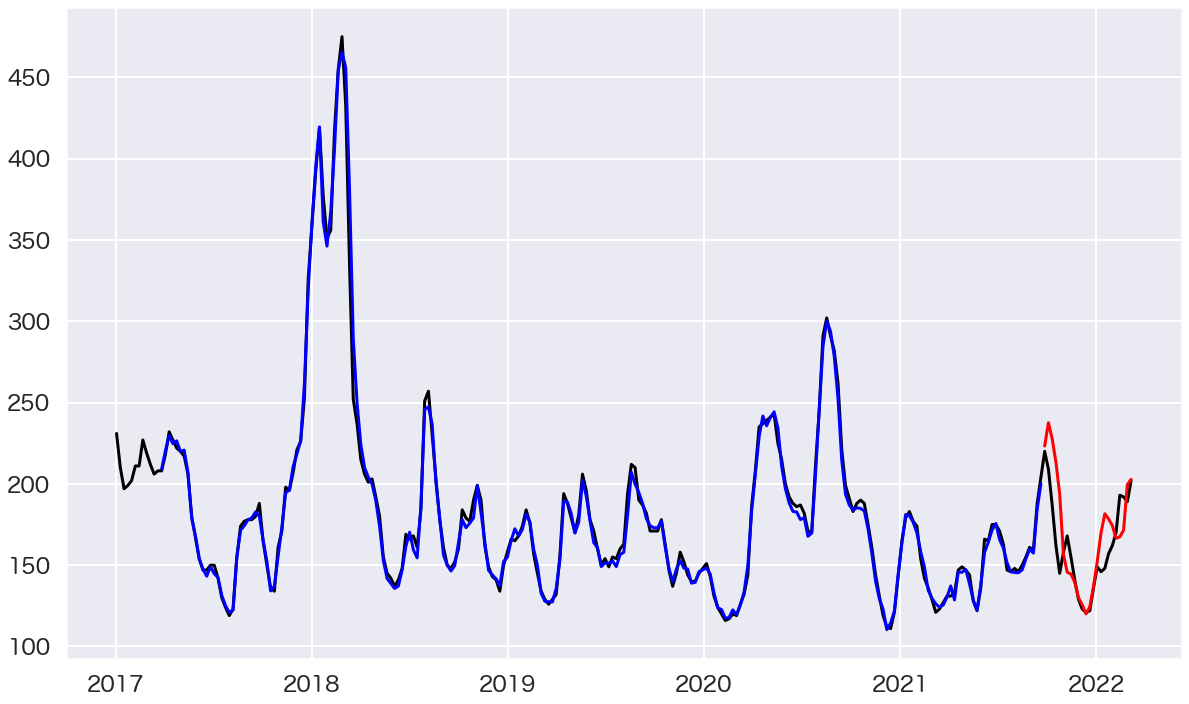

In [18]:
sns.set(context="poster",font="Hiragino Maru Gothic Pro")
fig = plt.subplots(figsize=(20,12))

#正解のプロット
plt.plot(df["キャベツ"],color="black")
# トレーニングデータのプロット
df_train_pred = pd.DataFrame(scaler_y.inverse_transform(predictions),
                       index=df[12:-24].index)
plt.plot(df_train_pred,color="blue")

# テストデータのプロット
df_train_pred = pd.DataFrame(scaler_y.inverse_transform(future_predictions),
                       index=df[-24:].index)
plt.plot(df_train_pred,color="red")

In [19]:
df_scale_X[-12:]

,キャベツ,愛知平均気温,愛知降水量の合計,愛知日照時間,千葉平均気温,千葉降水量の合計,千葉日照時間,群馬平均気温,群馬降水量の合計,群馬日照時間
調査日,,,,,,,,,,
2021-12-20,-1.032716,-1.137913,-0.275320,0.237317,-1.205739,-0.197861,0.433093,-1.035058,-0.066813,-0.500042
2021-12-27,-0.791868,-1.239338,-0.503456,-0.290350,-1.284079,-0.645608,0.954164,-1.223875,-0.614046,-0.520447
2022-01-03,-0.568222,-1.490134,-0.691915,-0.165376,-1.656720,-0.798497,0.706337,-1.485940,-0.566460,-0.302791
2022-01-10,-0.619833,-1.407150,-0.721672,0.424777,-1.529683,-0.503639,0.261520,-1.409436,-0.637839,0.350177
2022-01-17,-0.585426,-1.432967,-0.503456,-0.470867,-1.495806,-0.296147,0.541120,-1.427341,-0.328533,-1.418278
2022-01-24,-0.430595,-1.598936,-0.533212,-0.290350,-1.690596,-0.711132,0.560183,-1.653596,-0.614046,-0.486438
2022-01-31,-0.344577,-1.292816,-0.701834,-0.318122,-1.406881,-0.689290,-0.564568,-1.385020,-0.685424,1.016749
2022-02-07,-0.206950,-1.475381,-0.721672,-0.019574,-1.652485,-0.798497,0.890619,-1.554304,-0.637839,0.139323
2022-02-14,0.188730,-1.379489,-0.205888,-0.963819,-1.497924,1.079854,-1.155539,-1.380137,-0.126295,0.078107


In [20]:
df_f = df_scale_X[-12:].values.tolist()

In [21]:
df_f = np.array(df_f)

In [22]:
df_f = df_f.reshape(1,12,10)

In [23]:
future_f = model.predict(df_f)

In [24]:
scaler_y.inverse_transform(future_f)

array([[203.50746]], dtype=float32)

実際のキャベツの値段 202円

In [25]:
202-182.35522

19.644779999999997

In [26]:
model.save('model_alldata.h5')